# dsp4bats - plot chirp shapes

Uses the 'dsp4bats' library to plot sound shapes in a ZC style. Peak frequencies are calculate and stored as a dataframe before plotting.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# Add path from jupyter to the dsp4bats library.
import sys
path = ".."
sys.path.append(path)

In [3]:
import pathlib
import numpy as np
import pandas as pd
import dsp4bats

In [4]:
# Settings.
#jump_factor=8000
jump_factor=16000
#jump_factor=32000
max_size=256

print('Step length: ', 1000/jump_factor, ' ms.')

Step length:  0.0625  ms.


In [5]:
# Read the produced text file as a dataframe. Calculate and add more columns.
def read_metrics_from_file():
    # Read dataframe.
    peak_df = pd.read_csv(metrics_file_path, sep="\t")
    #
    return peak_df

In [6]:
# Read the produced text file as a dataframe. Calculate and add more columns.
def read_chirpshape_from_file():    
    # Read dataframe.
    chirpshape_df = pd.read_csv(chirpshape_file_path, sep="\t")
    # Add compressed time line.
    chirpshape_df['time_expanded_s'] = [x / jump_factor for x in range(0, len(chirpshape_df.index))]
    #
    return chirpshape_df

In [7]:
# Core functionality.
def read_file_and_extract_chirpshape():
    
    # Read signal from file.
    wave_reader = dsp4bats.WaveFileReader(sound_file_path)
    samp_width = wave_reader.samp_width
    frame_rate = wave_reader.frame_rate
    sampling_freq = wave_reader.sampling_freq
    
    # Create dsp4bats utils.
    signal_util = dsp4bats.SignalUtil(sampling_freq)
    spectrum_util = dsp4bats.DbfsSpectrumUtil(window_size=128,
                                              window_function='kaiser',
                                              kaiser_beta=14,
                                              sampling_freq=sampling_freq)
    # Prepare output file for chirp shapes.
    ##out_file_name = pathlib.Path(sound_file_path).stem + '_ChirpShape.txt'
    out_file = pathlib.Path(chirpshape_file_path).open('w')
    out_header = spectrum_util.chirp_shape_header()
    out_file.write('\t'.join(map(str, out_header)) + '\n')# Read until end of file.
    
    # Read file.
    found_peak_counter = 0
    buffer_number = 0
    # Read buffer, 1 sec.
    buffer_size = sampling_freq
    signal_1sec = wave_reader.read_buffer(buffer_size)
    
    # Iterate over buffers.
    while len(signal_1sec) > 0:

        # === Create text file for plotting in ZC style. ===

        for index, row_df in peak_df.iterrows():
            peak_index = int(row_df['peak_signal_index'])
            start_index = int(row_df['start_signal_index'])
            end_index = int(row_df['end_signal_index'])
            # Check if current buffer. TODO: Filter dataframe instead.
            if end_index >= ((buffer_number + 1) * buffer_size):
                continue
            if start_index < (buffer_number * buffer_size):
                continue
            peak_index -= buffer_number * buffer_size  
            start_index -= buffer_number * buffer_size
            end_index -= buffer_number * buffer_size
            # Extract shape peaks.
            peak_list = spectrum_util.chirp_shape(
                                        signal_1sec, peak_index, 
                                        start_index=start_index, 
                                        stop_index=end_index, 
                                        jump_factor=jump_factor, 
                                        max_size=max_size)
            #
            for peak_row in peak_list:
                time_s = peak_row[0]
                time_s = buffer_number * buffer_size / buffer_size + time_s
                peak_row[0] = time_s
                signal_index = peak_row[3]
                signal_index = buffer_number * buffer_size + signal_index
                peak_row[3] = signal_index
                #
                out_file.write('\t'.join(map(str, peak_row)) + '\n')
        #
        buffer_number += 1
        # Read next buffer.
        signal_1sec = wave_reader.read_buffer(buffer_size)

    # Done.
    print('Detected peak counter: ' + str(found_peak_counter))
    wave_reader.close()
    out_file.close()
    #
    return sampling_freq # We need this later...


In [8]:
# Plot two diagrams to visualise metrics.
def plot_diagrams():
    fig, (ax1, ax2) = plt.subplots(2,1,
                            figsize=(16, 10), 
                            dpi=150)
    # ax1 - peak freq, etc.
    cs1 = ax1.scatter(
                x=chirpshape_df.time_s,
                y=chirpshape_df.frequency_hz/1000,
                s=1,
                c=chirpshape_df.amplitude_dbfs,
                cmap=plt.get_cmap('Reds'),  #'YlOrRd'
                alpha=0.5)
    cbar = fig.colorbar(cs1, ax=ax1, label='dBFS')
    ax1.set_ylim((0,120))
    ax1.minorticks_on()
    ax1.grid(which='major', linestyle='-', linewidth='0.5', alpha=0.6)
    ax1.grid(which='minor', linestyle='-', linewidth='0.5', alpha=0.3)
    ax1.tick_params(which='both', top='off', left='off', right='off', bottom='off')
    
    # ax2 - interval.
    cs2 = ax2.scatter(
                x=chirpshape_df.time_expanded_s,
                y=chirpshape_df.frequency_hz/1000,
                s=1,
                c=chirpshape_df.amplitude_dbfs,
                cmap=plt.get_cmap('Reds'),  #'YlOrRd'
                alpha=0.5
                )    
    ax2.set_ylim((0,120))
    ax2.minorticks_on()
    ax2.grid(which='major', linestyle='-', linewidth='0.5', alpha=0.6)
    ax2.grid(which='minor', linestyle='-', linewidth='0.5', alpha=0.3)
    ax2.tick_params(which='both', top='off', left='off', right='off', bottom='off') 
    
    # Adjust size on second diagram.
    pos = ax1.get_position()
    pos2 = ax2.get_position()
    ax2.set_position([pos.x0,pos2.y0,pos.width,pos2.height])
    
    # Titles and labels.
    file_name = pathlib.Path(sound_file_path).name
    fig.suptitle('Shapes from: ' + file_name, 
                 fontsize=12, fontweight='bold', ha='right')
    ax1.set_title('Peak and amplitude')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Frequency (kHz)')
    ax2.set_title('Expanded time (silent parts removed)')
    ax2.set_xlabel('Expanded time (s)')
    ax2.set_ylabel('Frequency (kHz)')
    
    # Save and plot.
    fig.savefig(plot_file_path)
    plt.show()

Detected peak counter: 0


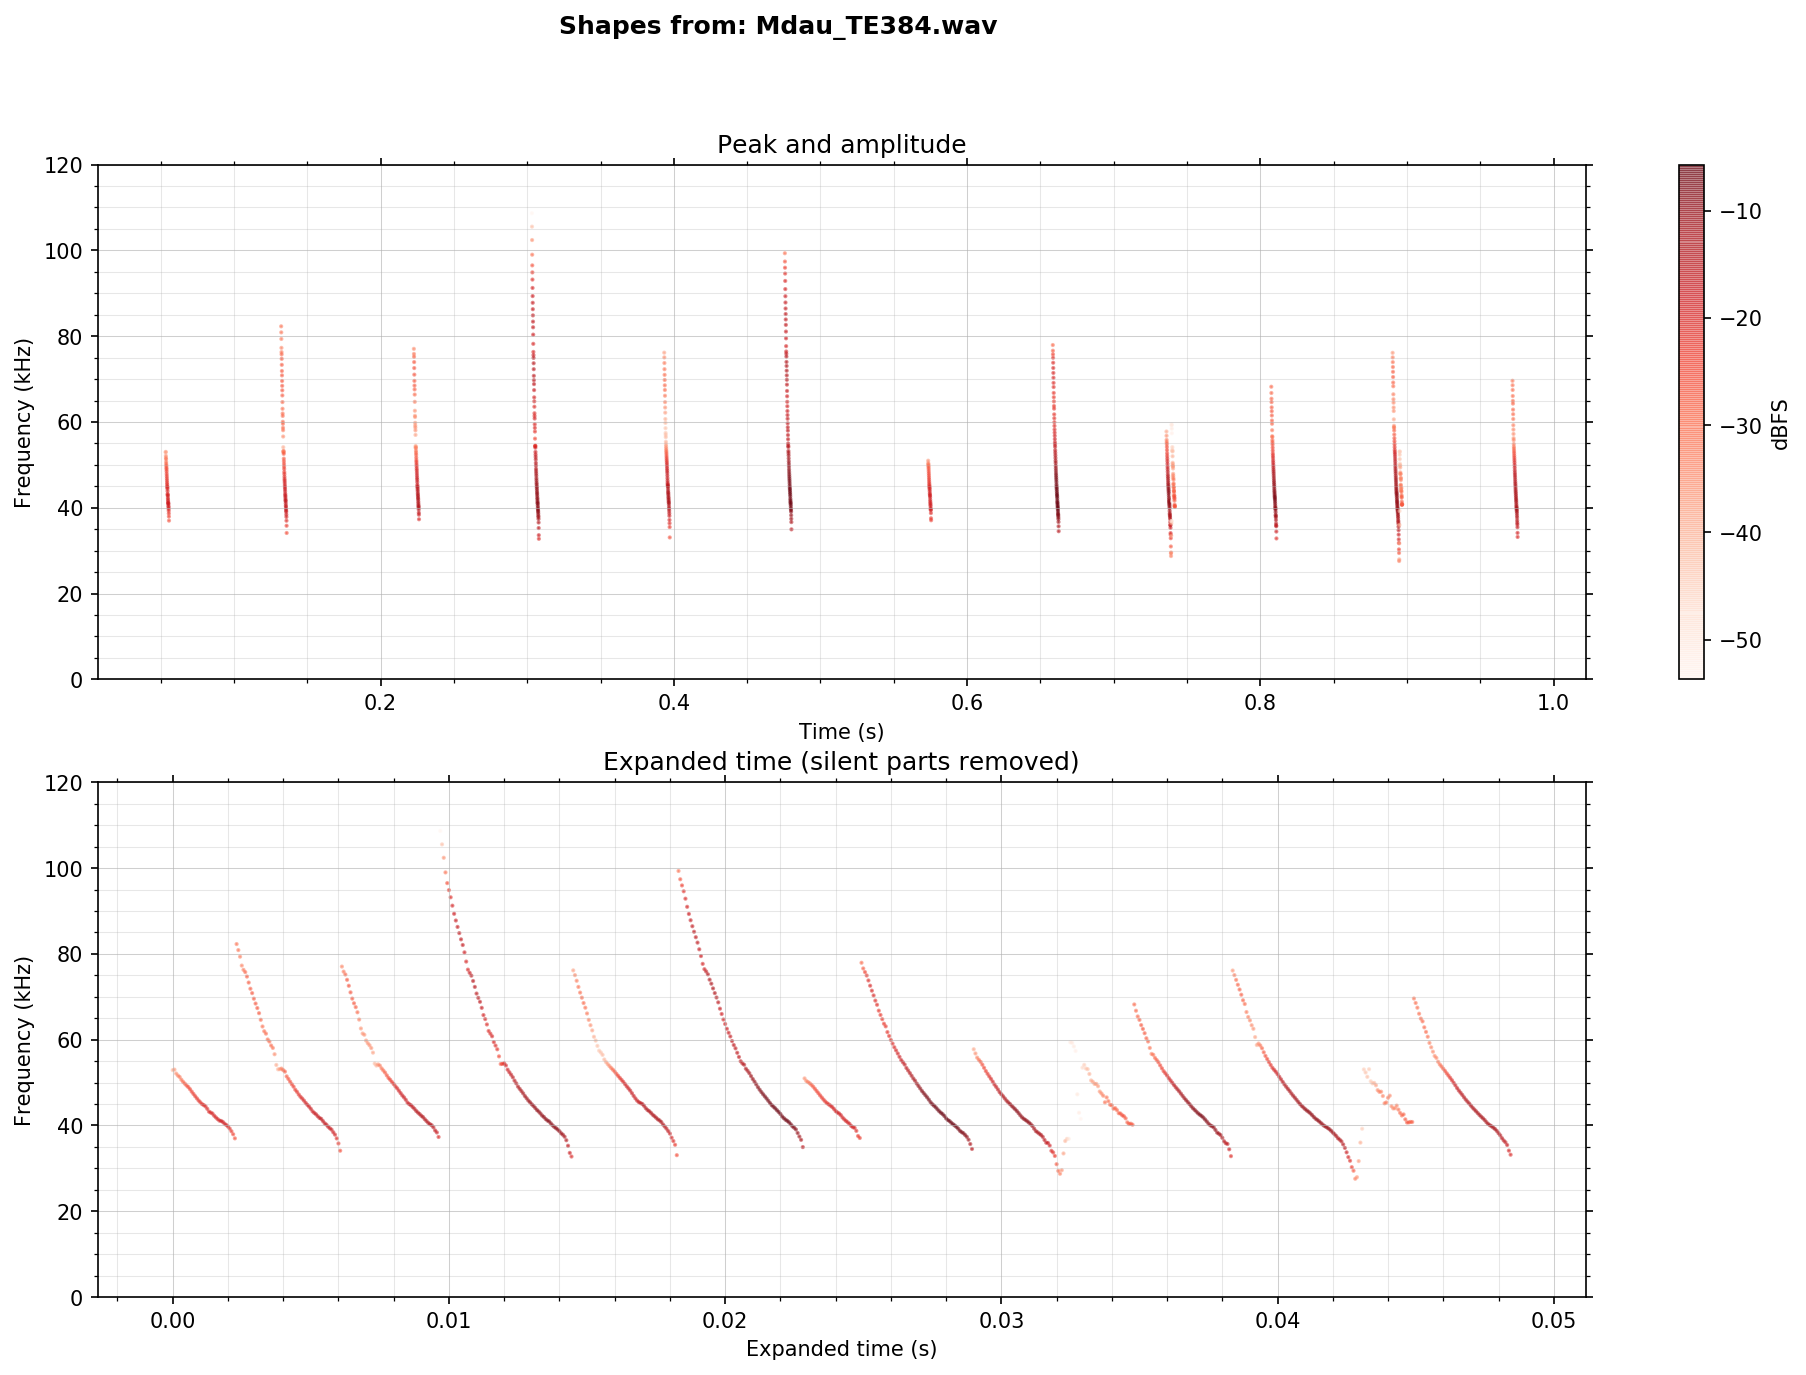

In [9]:
# Calculate and plot metrics for Mdau.

# Settings.
sound_file_path = 'data_in/Mdau_TE384.wav'
metrics_file_path = 'data_out/Mdau_TE384_Metrics.txt'
chirpshape_file_path = 'data_out/Mdau_TE384_ChirpShape.txt'
plot_file_path = 'data_out/Mdau_TE384_ChirpShape.png'
# Run it.
peak_df = read_metrics_from_file()
sampling_freq = read_file_and_extract_chirpshape()
chirpshape_df = read_chirpshape_from_file()
plot_diagrams()

In [10]:
# View dataframe for Mdau.
chirpshape_df

,time_s,frequency_hz,amplitude_dbfs,signal_index,time_expanded_s
0,0.05344,52914.0,-40.5,20520,0.000000
1,0.05350,53029.0,-36.5,20544,0.000063
2,0.05356,52111.0,-34.6,20568,0.000125
3,0.05362,51641.0,-32.9,20592,0.000188
4,0.05369,51320.0,-31.1,20616,0.000250
...,...,...,...,...,...
771,0.97519,36507.0,-14.8,374472,0.048188
772,0.97525,36089.0,-15.5,374496,0.048250
773,0.97531,35452.0,-16.7,374520,0.048313
774,0.97538,34142.0,-18.8,374544,0.048375


Detected peak counter: 0


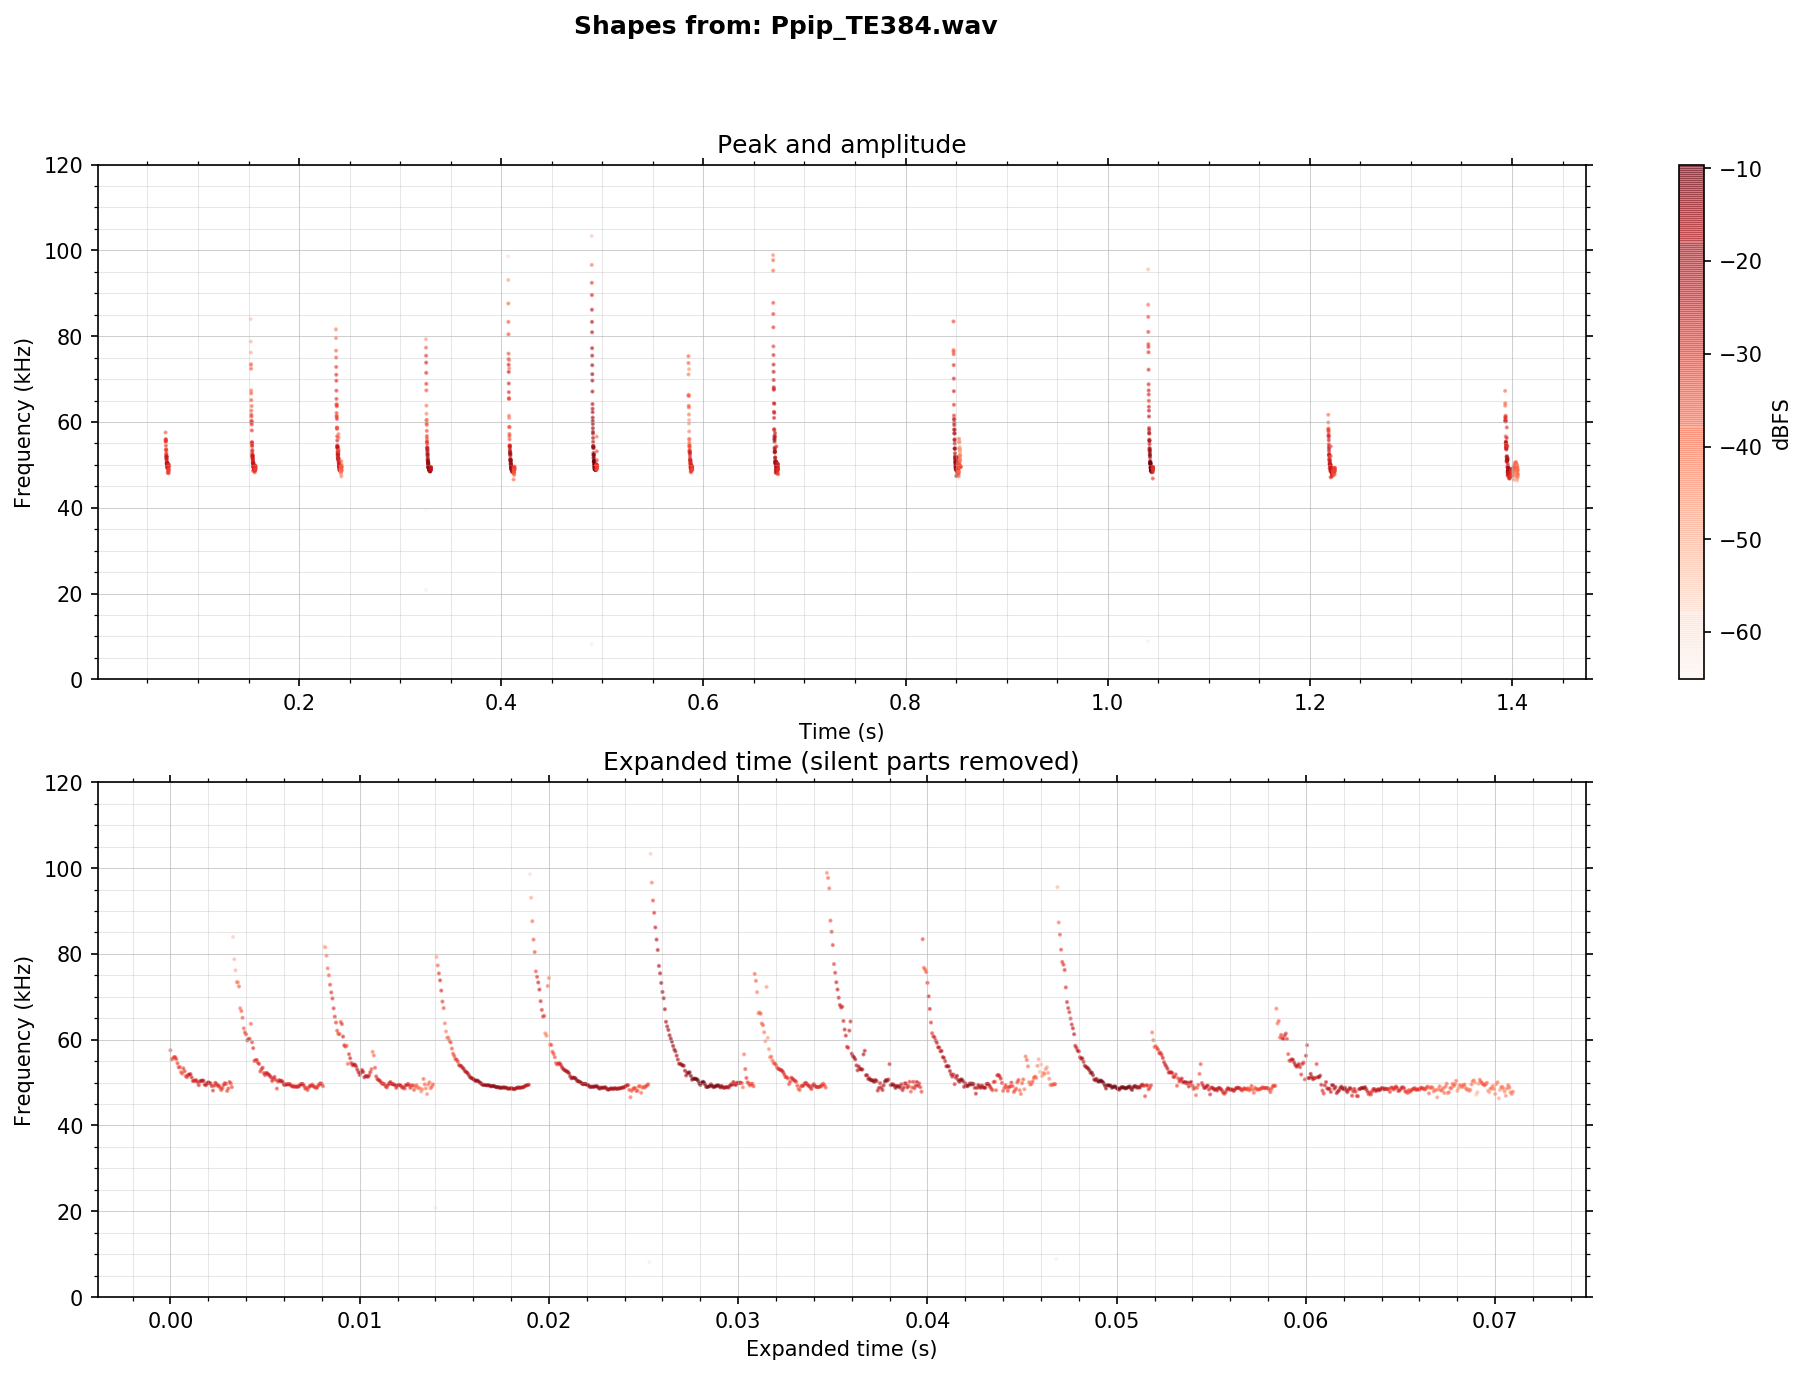

In [11]:
# Calculate and plot metrics for Ppip.

# Settings.
sound_file_path = 'data_in/Ppip_TE384.wav'
metrics_file_path = 'data_out/Ppip_TE384_Metrics.txt'
chirpshape_file_path = 'data_out/Ppip_TE384_ChirpShape.txt'
plot_file_path = 'data_out/Ppip_TE384_ChirpShape.png'
# Run it.
peak_df = read_metrics_from_file()
sampling_freq = read_file_and_extract_chirpshape()
chirpshape_df = read_chirpshape_from_file()
plot_diagrams()

In [12]:
# View dataframe for Ppip.
chirpshape_df

,time_s,frequency_hz,amplitude_dbfs,signal_index,time_expanded_s
0,0.06794,57539.0,-34.9,26088,0.000000
1,0.06800,55409.0,-37.1,26112,0.000063
2,0.06806,55568.0,-34.5,26136,0.000125
3,0.06813,55918.0,-30.6,26160,0.000188
4,0.06819,55948.0,-28.0,26184,0.000250
...,...,...,...,...,...
1131,1.40544,49379.0,-36.5,539688,0.070688
1132,1.40550,48842.0,-37.5,539712,0.070750
1133,1.40556,47728.0,-40.0,539736,0.070813
1134,1.40562,47341.0,-40.7,539760,0.070875


Detected peak counter: 0


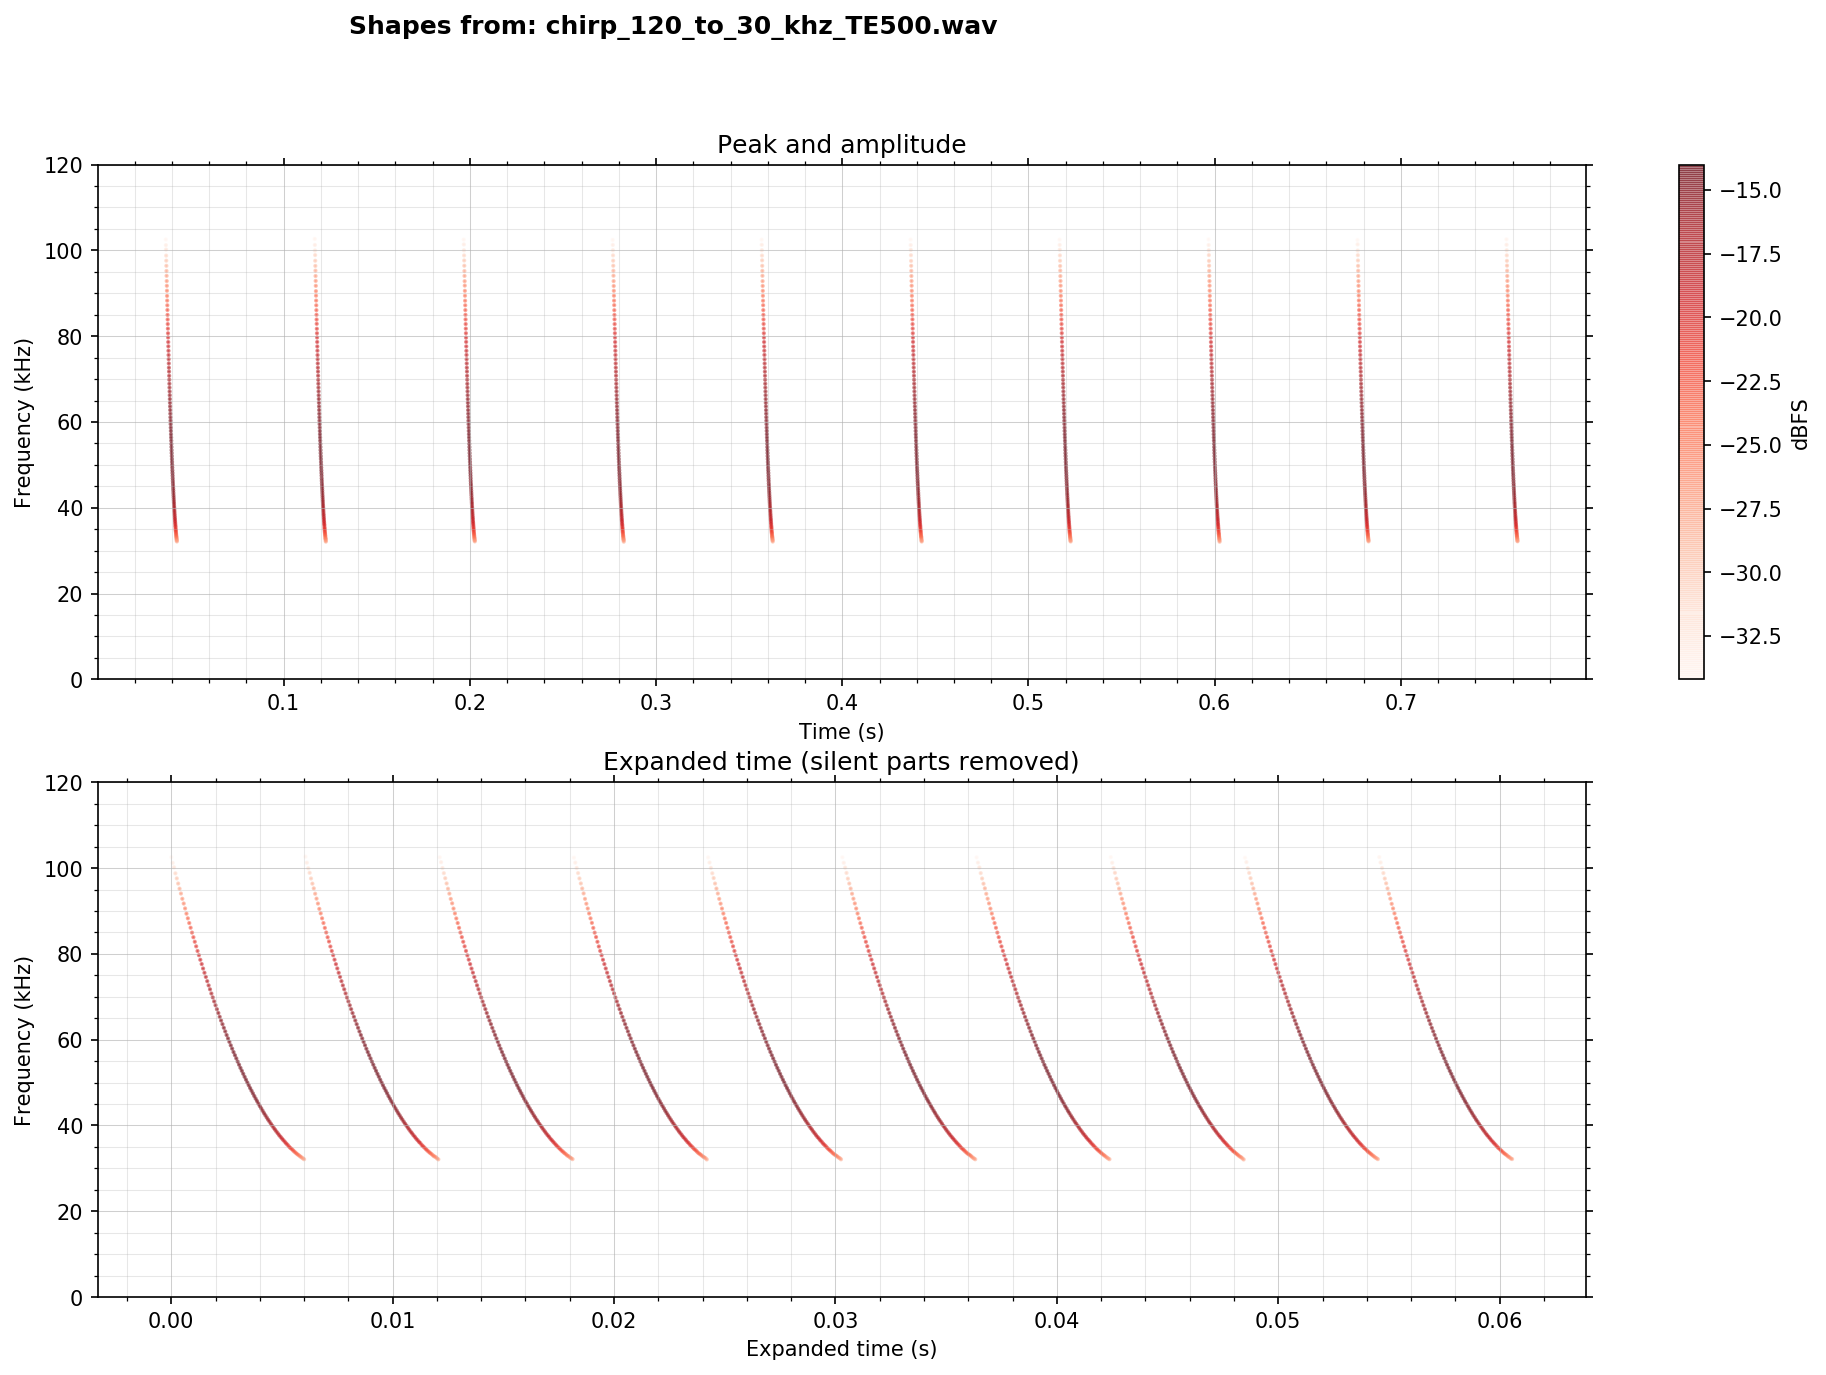

In [13]:
# Calculate and plot metrics for syntetic chirps.

# Settings.
sound_file_path = 'data_out/chirp_120_to_30_khz_TE500.wav'
metrics_file_path = 'data_out/chirp_TE500_Metrics.txt'
chirpshape_file_path = 'data_out/chirp_TE500_ChirpShape.txt'
plot_file_path = 'data_out/chirp_TE500_ChirpShape.png'
# Run it.
peak_df = read_metrics_from_file()
sampling_freq = read_file_and_extract_chirpshape()
chirpshape_df = read_chirpshape_from_file()
plot_diagrams()